In [1]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
import torch

iid_data =  datasets.FashionMNIST(root='data/FMNIST',download=True,train=True) 
num_classes = len(iid_data.classes)
alpha = 1 # if alpha is small --> increasing non-iidness, or if alpha is large --> increasing iidness
num_worker = 10 # Number of client in federated learning

In [2]:
dir(iid_data)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_format_transform_repr',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [21]:
iid_data.data.shape[0]

60000

In [30]:
iid_data.train_labels

tensor([9, 0, 0,  ..., 3, 0, 5])

In [32]:
np.where(iid_data.targets == 1)[0].shape

array([   16,    21,    38, ..., 59989, 59991, 59996])

In [9]:
iid_data.class_to_idx.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
iid_data.targets.shape

torch.Size([60000])

In [13]:
iid_data.data.shape

torch.Size([60000, 28, 28])

In [15]:
iid_data.train_data.shape

torch.Size([60000, 28, 28])

In [10]:
idx[0][0].size()

torch.Size([6000])

In [39]:
np.random.dirichlet([1,1,100,1,1], 3)

array([[1.73281251e-03, 7.28674070e-04, 9.87150459e-01, 8.77186661e-03,
        1.61618828e-03],
       [4.20737401e-02, 4.43690287e-03, 9.43166890e-01, 1.11248357e-03,
        9.20998395e-03],
       [4.33251203e-03, 2.79778736e-02, 9.37563539e-01, 1.40402205e-02,
        1.60858553e-02]])

In [26]:
np.random.dirichlet([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

array([5.90540954e-02, 1.04734867e-01, 1.45005884e-04, 1.81618145e-02,
       9.86518958e-02, 8.09314330e-02, 6.13825080e-02, 1.36866109e-01,
       9.51916822e-02, 3.44880589e-01])

In [175]:
iid_data =  datasets.MNIST(root='data/MNIST',download=True,train=True) 

In [185]:
len(iid_data.targets)

60000

In [176]:
dataset = iid_data
num_clients = 10
min_size = 0
num_classes = len(dataset.classes)
num_all_data = dataset.data.shape[0] # dataset.shape = 60000,28,28 for FMNIST
net_dataidx_map = {}
least_samples = 10
while min_size < least_samples:
    idx_batch = [[] for _ in range(num_clients)]
    # idx_batch is a list stores data_index for clients. initialized as empty and increases step by step
    for k in range(num_classes):
        idx_k = np.where(dataset.targets == k)[0]
        # locate index belong to data from class k
        np.random.shuffle(idx_k)
        # introduce randomness?
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # generate sampling probabilities, [p_1,p_2,...p_K] \sum_{i=1}^{K}(p_i)=1
        proportions = np.array([p * (len(idx_j) < num_all_data / num_clients) for p, idx_j in zip(proportions,
                                                                                                  idx_batch)])
        # check the probabilities lsit, if client j has gain enough samples,
        # tthen his sampling probability is set to 0 for this round and afterward
        proportions = proportions / proportions.sum()
        # resize the prob list
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        # calculate the cumulative sum of proba list, rule out the last element(which i think is unnecessary)
        idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
        # update idx_batch, distribute samples from class k accorss all clients
    min_size = min([len(idx_j) for idx_j in idx_batch])
    # calulate min_size to see whether need to re-sampling
    
for j in range(num_clients):
    np.random.shuffle(idx_batch[j])
    net_dataidx_map[j] = idx_batch[j]

In [189]:
[len(net_dataidx_map[i]) for i in range(10)]

[5288, 6861, 7165, 5343, 7053, 4728, 6548, 7552, 3112, 6350]

In [177]:
[len(idx_batch[i]) for i in range(10)]

[5288, 6861, 7165, 5343, 7053, 4728, 6548, 7552, 3112, 6350]

In [178]:
labels =[[] for _ in range(num_clients)]
for i in range(10):
    for index in idx_batch[i]:
        _,lable = iid_data[index]
        labels[i].append(lable)

In [179]:
[len(labels[i]) for i in range(10)]

[5288, 6861, 7165, 5343, 7053, 4728, 6548, 7552, 3112, 6350]

In [180]:
count_matrix = [[] for _ in range(num_clients)]
for client_idx in range(num_clients):
    count_matrix[client_idx] = [labels[client_idx].count(i) for i in range(num_classes)]      
count_matrix

[[776, 788, 122, 76, 176, 69, 1114, 854, 888, 425],
 [537, 1125, 1521, 494, 1586, 618, 980, 0, 0, 0],
 [2273, 1653, 373, 1069, 592, 1205, 0, 0, 0, 0],
 [415, 192, 154, 486, 47, 167, 747, 529, 1365, 1241],
 [822, 772, 544, 946, 152, 675, 1437, 219, 1486, 0],
 [46, 472, 298, 373, 113, 313, 592, 519, 32, 1970],
 [173, 385, 523, 592, 367, 844, 569, 3095, 0, 0],
 [84, 420, 1042, 287, 606, 114, 357, 894, 2026, 1722],
 [238, 12, 72, 1162, 648, 61, 121, 155, 53, 590],
 [559, 923, 1309, 646, 1555, 1355, 1, 0, 1, 1]]

[Text(0.5, 69.0, 'class index'), Text(69.0, 0.5, 'client index')]

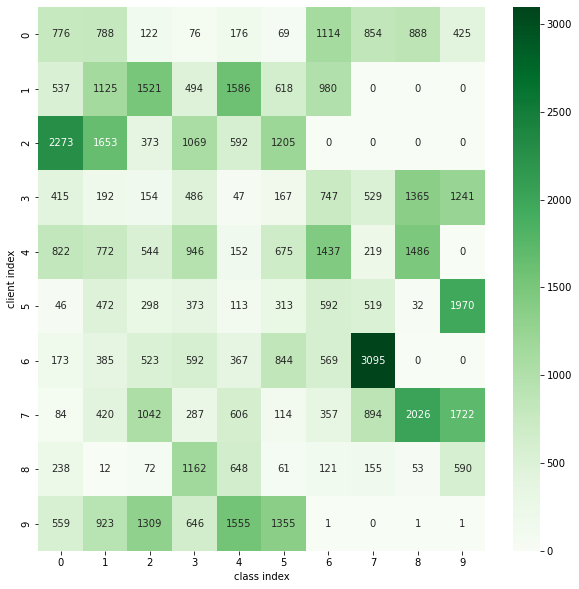

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,10))
figure = sns.heatmap(count_matrix,annot=True,annot_kws={'size':10},fmt='.20g',cmap='Greens',ax=ax)
figure.set(xlabel = 'class index',ylabel = 'client index')

In [190]:
def plot_dis(dataset, client_dataidx_map):
    num_clients = len(client_dataidx_map.keys())
    num_classes = len(dataset.classes)
    labels = [[] for _ in range(num_clients)]
    for i in range(10):
        for index in client_dataidx_map[i]:
            _, lable = dataset[index]
            labels[i].append(lable)

    count_matrix = [[] for _ in range(num_clients)]
    for client_idx in range(num_clients):
        count_matrix[client_idx] = [labels[client_idx].count(i) for i in range(num_classes)]

    fig, ax = plt.subplots(figsize=(10, 10))
    figure = sns.heatmap(count_matrix, annot=True, annot_kws={'size': 10},
                         fmt='.20g', cmap='Greens', ax=ax)
    figure.set(xlabel='class index', ylabel='client index')
    return figure

<AxesSubplot:xlabel='class index', ylabel='client index'>

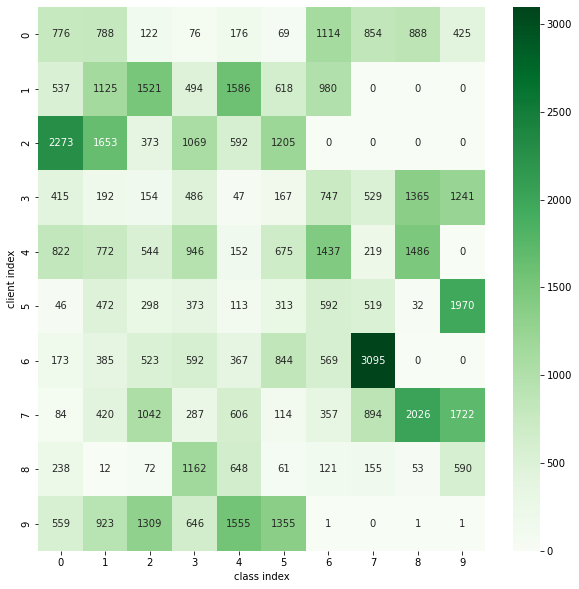

In [191]:
plot_dis(iid_data, net_dataidx_map)

In [71]:
(np.cumsum(proportions)*len(idxs)).astype(int)[:-1]

array([3149, 3198, 3266, 3562, 3700, 3729, 4022, 4061, 4712])

In [72]:
(np.cumsum(proportions)*len(idxs)).astype(int)

array([3149, 3198, 3266, 3562, 3700, 3729, 4022, 4061, 4712, 6000])

In [73]:
proportions1 = (np.cumsum(proportions)*len(idxs)).astype(int)
batch_idxs = np.split(idxs,proportions1)
net_dataidx_map = {i: batch_idxs[i] for i in range(10)}
net_dataidx_map

{0: array([2340, 3158, 4842, ..., 5466, 2228, 2675]),
 1: array([4752, 3995, 1520, 4743, 5689, 4196, 2518, 4292, 1024, 2550, 3097,
        1568, 3865, 1467, 1952, 2486, 2384, 4148, 1791, 5758, 3864, 2306,
        2980, 1694, 2026, 2209,  722,  985,  410, 1287, 5283, 3000, 4053,
        3433, 2618, 3820, 4282, 5997,  788, 2446, 3403, 1036,  876,  284,
        1383, 3897, 1913, 1900, 5391]),
 2: array([ 557, 5739, 2548, 3355, 4705,  289, 5657, 5202, 1110, 1761, 4990,
        2962, 4316, 2539, 4954, 4784,  820, 4544, 2152, 4334, 4803, 1739,
        4967, 1328, 4952, 5830, 5940,  447, 5956, 2383, 2311, 5905, 5540,
        3330, 2775, 4561, 3153, 5196, 2239, 5519, 4021, 4569, 1297,    6,
         302, 2815, 4968, 1843, 1455, 4989, 3901, 4781, 3690, 1346, 5016,
        4859, 2650, 2146, 2597, 4554, 2309, 3798, 5713, 4323,  119, 3404,
         867, 1693]),
 3: array([2274, 5226, 2255, 4455, 3929, 1210,  672, 1570, 4390, 3857, 1012,
        3051, 4662, 5116, 4493, 5139,  918, 2756, 5886, 5525,

In [75]:
proportions2 = (np.cumsum(proportions)*len(idxs)).astype(int)
batch_idxs = np.split(idxs,proportions2)
net_dataidx_map2 = {i: batch_idxs[i] for i in range(10)}
proportions2

array([3149, 3198, 3266, 3562, 3700, 3729, 4022, 4061, 4712, 6000])

In [76]:
proportions1

array([3149, 3198, 3266, 3562, 3700, 3729, 4022, 4061, 4712])

In [84]:
len(net_dataidx_map2[9])

1288

In [86]:
len(net_dataidx_map[9])

1288

In [87]:
1288+4712

6000

In [89]:
net_dataidx_map[1].tolist()

[4752,
 3995,
 1520,
 4743,
 5689,
 4196,
 2518,
 4292,
 1024,
 2550,
 3097,
 1568,
 3865,
 1467,
 1952,
 2486,
 2384,
 4148,
 1791,
 5758,
 3864,
 2306,
 2980,
 1694,
 2026,
 2209,
 722,
 985,
 410,
 1287,
 5283,
 3000,
 4053,
 3433,
 2618,
 3820,
 4282,
 5997,
 788,
 2446,
 3403,
 1036,
 876,
 284,
 1383,
 3897,
 1913,
 1900,
 5391]

In [90]:
index = 0
while index < 10:
    for i in range(10):
        index += 2
index

20

In [91]:
A=[1,2,3,4,5]

In [92]:
np.random.shuffle(A)

In [93]:
A

[5, 2, 4, 3, 1]

In [193]:
print("{:.2f}%".format(0.8541*100))

85.41%
